~~~Training on GPU will be fine for transfer learning as it is not a very demanding process.~~~

We are going to train this model with TPU.

Adapted from [Keras and modern convnets, on TPUs
](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/index.html) from Martin Görner.

## Imports

In [0]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.
Tensorflow version 2.1.0


# Hardware Configuration
This code snippet works for the following hardware accelerators:
- TPU (recommended).
- GPU.

Adapted from [Keras and modern convnets, on TPUs
](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/index.html) and [Keras Flowers on TPU (playground)](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_playground.ipynb) from Martin Görner.

**Important:** For the TPU to work, you need to declare your models `with strategy.scope()`.


In [0]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.116.2.26:8470


INFO:tensorflow:Initializing the TPU system: 10.116.2.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.116.2.26:8470
Number of accelerators:  8


# Fetch and Parse Kaggle Conpetition Datasheets
Tensorflow's datasheet format seems to be more intuitive and straight-forward than Numpy Arrays. Most importantly, they work out-of-the-box with TPUs. Since we are using Tensorflow for training, it might be helpful to use the built-in Tensorflow data format.

In [0]:
SCALE_UP_RATIO = 2
IMAGE_SIZE = [SCALE_UP_RATIO * 28, SCALE_UP_RATIO * 28]
# IMAGE_SIZE = [71, 71]

In [0]:
# https://stackoverflow.com/questions/46614526/how-to-import-a-csv-file-into-a-data-array
# https://stackoverflow.com/questions/48889482/feeding-npy-numpy-files-into-tensorflow-data-pipeline
import csv
import os

import cv2
from tqdm import tqdm
os.environ['KAGGLE_USERNAME'] = "jacobthebanana"
os.environ['KAGGLE_KEY'] = "d5932a01a9227207eca15bfdfd0a503a"
 
!kaggle competitions download -c winter2020-mais-202

# Unzip quietly withou overwriting anything that already exists.
!unzip -nq test_images.npy.zip
!unzip -nq train_images.npy.zip

# Load npy files, and convert to Tensorflow datasets.
# Load the training data into a Numpy array and the labels into a list.
np_data = np.load("train_images.npy")

# Adapted from Zoë's hack for monochromatic images
rgb_data = list()

for img in tqdm(np_data):
  img = img.astype('float32')
  img = cv2.resize(img, tuple(IMAGE_SIZE))
  rbg_img = np.stack((img, img, img), axis=2)
  rgb_data.append(rbg_img)

np_data = np.asarray(rgb_data)

label_csv = open('train_labels.csv', newline='')    
labels = list(csv.reader(label_csv))[1:]
labels = [float(label[1]) for label in labels] 

# Assume that each row of `features` corresponds to the same row as `labels`.
assert np_data.shape[0] == len(labels)

# Generate one-hot labels.
def get_onehot_label(numerical_label): # Gives a 1D-tensor
  output = [0 for i in range(10)]
  output[int(numerical_label)] = 1
  return tf.convert_to_tensor(output)

labels = [get_onehot_label(label) for label in labels]

# Actually load the dataset into Tensorflow
dataset = tf.data.Dataset.from_tensor_slices((np_data, labels))

# Load the name for each category.
with open('label_int_to_str_mapping.csv', newline='') as csvfile:
    label_int_to_str_mapping = list(csv.reader(csvfile))[1:]

  0% 0.00/429k [00:00<?, ?B/s]
100% 429k/429k [00:00<00:00, 64.9MB/s]
 97% 50.0M/51.7M [00:01<00:00, 28.3MB/s]
100% 51.7M/51.7M [00:01<00:00, 46.5MB/s]
  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 54.1MB/s]
  0% 0.00/127 [00:00<?, ?B/s]
100% 127/127 [00:00<00:00, 129kB/s]
 82% 17.0M/20.7M [00:00<00:00, 168MB/s]
100% 20.7M/20.7M [00:00<00:00, 132MB/s]


100%|██████████| 50000/50000 [00:02<00:00, 18850.13it/s]


## Configuration
**Note.** The TPUs ask us to explicitly state the dimensions (shape) of our input. Although we know what's our image size, we have to specify that.

In [0]:


if tpu:
  BATCH_SIZE = 16 * strategy.num_replicas_in_sync # We get 8 TPU cores, so BATCH_SIZE would be 128.
else:
  BATCH_SIZE = 32

EPOCHS = 5

VALIDATION_SPLIT = 0.19
CLASSES = label_int_to_str_mapping

# splitting data files between training and validation
split = int(len(np_data) * VALIDATION_SPLIT)

size = len(np_data)
train_size = int(size * (1 - VALIDATION_SPLIT))
test_size = int(size * VALIDATION_SPLIT)

training_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print("Found {} data files. Splitting dataset into {} training files and {} validation files".format(size, train_size, test_size))
validation_steps = int(size * (1 - VALIDATION_SPLIT)) // BATCH_SIZE
steps_per_epoch = int(size * VALIDATION_SPLIT) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Found 50000 data files. Splitting dataset into 40500 training files and 9500 validation files
With a batch size of 128, there will be 74 batches per training epoch and 316 batch(es) per validation run.


## Preview of dataset
Let's see what one entry looks like. We are expecting `int32` for both the image and the one_hot label.

In [0]:
for image, label in training_dataset.take(1):
  # print(image)
  print(tf.cast(label, tf.float32))

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Pre-process inputs

In [0]:
[*IMAGE_SIZE, 1] # The asterisk expands the IMAGE_SIZE tuple

[56, 56, 1]

In [0]:
def normalize(image, class_label):
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  class_label = tf.cast(class_label, tf.float32)
  
  return image, class_label

def data_augment(image, label):
  image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_saturation(image, lower=0, upper=2)
  return image, label

## training and validation datasets

In [0]:
def get_batched_dataset(input_dataset, train=False, argument_data=True):
  dataset = input_dataset.map(normalize)
  dataset = dataset.cache() # Assuming that this dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
    if argument_data:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_dataset, train=True)
validation_dataset = get_batched_dataset(validation_dataset, train=False)

## Model [WORK REQUIRED]
1. Start with a dummy single-layer model using one dense layer:
 * Use  a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model. The constructor takes a list of layers.
 * First, [`Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the pixel values of the the input image to a 1D vector so that a dense layer can consume it:<br/>
 `tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3])  # the first layer must also specify input shape`
 * Add a single [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers):<br/>
  `tf.keras.layers.Dense(5, activation='softmax')`
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need `'sparse_categorical_crossentropy'` loss, `'accuracy'` in metrics and you can use the `'adam'` optimizer.

 **==>Train this model: not very good... but all the plumbing is in place.**

1. Instead of trying to figure out a better architecture, we will adapt a pretrained model to our data. Please remove all your layers to restart from scratch.
 * Instantiate a pre-trained model from `tf.keras.applications.*`
 You do not need its final softmax layer (`include_top=False`) because you will be adding your own. This code is already written in the cell below.<br/>
 * Use `pretrained_model` as your first "layer" in your Sequential model.
 * Follow with  [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) to turn the data from the pretrained model into a flat 1D vector.
 * Add your [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers).

 **==>Train the model: you should be able to reach above 75% accuracy by training for 10 epochs**

1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last one which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.

This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

In [0]:
for image, label in training_dataset.take(1):
  print(image.shape)
  print(label.shape)
  # print(image)
  print(label)

(128, 56, 56, 3)
(128, 10)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]], shape=(128, 10), dtype=float32)


In [0]:
# pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])



with strategy.scope(): # Tensorflow wants us to declare and compile our model within this "scope".
  # pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],  include_top=False)
  pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
  pretrained_model.trainable = True
  x = pretrained_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  # We got only 10 categories.
  predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
  print(x.shape)

  model2 = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions) 
  model2.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

  def fire(x, squeeze, expand):
    y = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=2, padding='same', activation='relu')(y)
    y2 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=2, padding='same', activation='relu')(y)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
    y4 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=4, padding='same', activation='relu')(y)
    return tf.keras.layers.concatenate([y1, y2, y3, y4])

  # this is to make it behave similarly to other Keras layers
  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  # usage:
  x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
  y = tf.keras.layers.BatchNormalization(momentum=0.99)(y) # We've got a huge dataset
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = tf.keras.layers.Dropout(0.2)(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(10, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    #
    # YOUR CODE HERE
    optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',
    # It took me hours to figure out that we don't need "sparse" here for our categories are discrete.
    # I wish I had a better understanding of loss functions beforehand.
    metrics=['accuracy']

    # 
  )

# history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)

pretrained_model.summary()

(None, 1024)
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 56, 56, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 28, 28, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 28, 28, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 28, 28, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 14, 14, 128)

In [0]:
# pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
# #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
# #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
# #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
# pretrained_model.trainable = False

# model = tf.keras.Sequential([
#   #
#   # YOUR CODE HERE
#   pretrained_model,
#   tf.keras.layers.Flatten(), 
#   tf.keras.layers.Dense(5, activation='softmax')
#   #
# ])

# model.compile(
#   #
#   # YOUR CODE HERE
#   optimizer="adam", loss='sparse_categorical_crossentropy',
#   metrics=['accuracy']
#   # 
# )

# history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)
# # history = None

# model.summary()

In [0]:
with strategy.scope(): # Tensorflow wants us to declare and compile our model within this "scope".
  # pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3],  include_top=False)
  pretrained_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])

  for layer in pretrained_model.layers:
    layer.trainable = False

  x = pretrained_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  # We got only 10 categories.
  predictions = tf.keras.layers.Dense(10, activation='softmax')(x)
  print(x.shape)

  model2 = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions) 
  model2.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

(None, 1024)


In [0]:
# !pip install tensorboard
filepath = 'cv-tricks_fine_tuned_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',period=1)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=15,
                    validation_data=validation_dataset)

Train for 74 steps, validate for 75 steps
Epoch 1/15
74/74 [==============================] - 19s 262ms/step - loss: 2.3014 - accuracy: 0.1101 - val_loss: 2.2981 - val_accuracy: 0.0891
Epoch 2/15
74/74 [==============================] - 3s 47ms/step - loss: 2.2934 - accuracy: 0.1464 - val_loss: 2.2950 - val_accuracy: 0.1718
Epoch 3/15
41/74 [===============>..............] - ETA: 0s - loss: 2.2784 - accuracy: 0.1713

In [0]:
file = 'model.csv'
model.save("model.csv")
print(file)

INFO:tensorflow:Assets written to: model.csv/assets
model.csv


## Training

In [0]:
print(model.metrics_names)

['loss', 'accuracy']


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


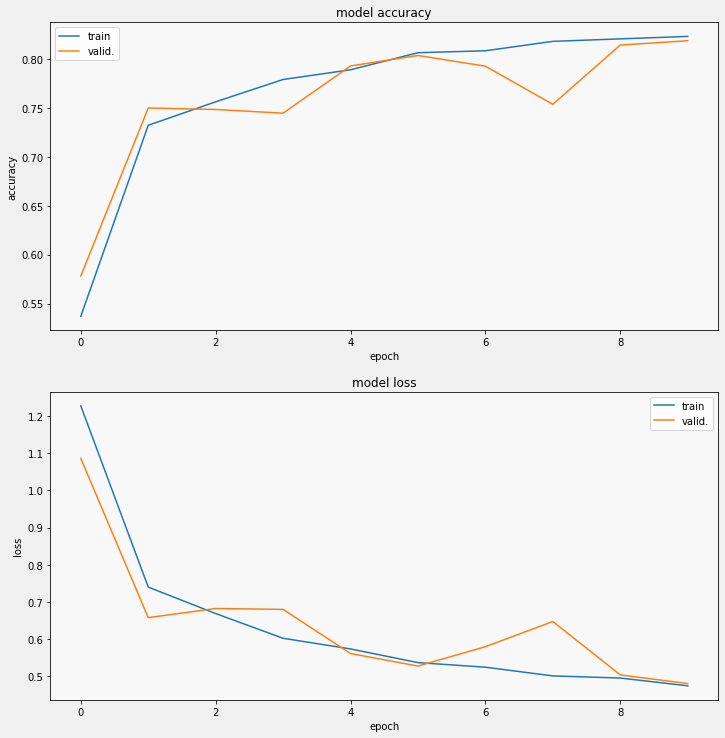

In [0]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [0]:
model.save("vgg19-dense.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vgg19-dense.model/assets


## Predictions

In [0]:
# random input: execute multiple times to change results
#flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

#predictions = model.predict(flowers, steps=1)
#print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

NameError: ignored

In [0]:
#display_9_images_with_predictions(flowers, predictions, labels)

In [0]:
test_images = np.load("test_images.npy")
train_data = np.load("train_images.npy")
import matplotlib.pyplot as plt

# test_data = [image[:][:] for image in tqdm(test_images[:])]

miscategorized = list()

test_data = list()

for img in tqdm(test_images):
  img = img.astype('float32')
  img = cv2.resize(img, tuple(IMAGE_SIZE))
  rbg_img = np.stack((img, img, img), axis=2)
  test_data.append(rbg_img)

test_data = tf.data.Dataset.from_tensor_slices(test_data)


def normalize_test(image):
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range  
  image = tf.reshape(image, (*IMAGE_SIZE, 3))
  return image

test_data = test_data.map(normalize_test)

def get_batched_testing_dataset(input_dataset, train=False, argument_data=True):
  # dataset = input_dataset.map(normalize_test)
  dataset = input_dataset
  dataset = dataset.cache() # Assuming that this dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
    # if argument_data:
    #   dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

testing_dataset = get_batched_testing_dataset(test_data)



In [0]:
keras = tf.keras 

predictions = model.predict(testing_dataset)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
for num, prediction in enumerate(predictions[:60]):
  prediction = np.argmax(prediction)
  img_data = test_images[num]

  y = fig.add_subplot(6, 10, num+1)
  orig = img_data

  str_label = label_int_to_str_mapping[int(prediction)][1]

  y.imshow(orig, cmap='gray')
  plt.title(str_label)
  y.axes.get_xaxis().set_visible(False)
  y.axes.get_yaxis().set_visible(False)

plt.show


with open('submission-file.csv', 'w') as f:
  f.write('ID,label\n')

with open('submission-file.csv', 'a') as f:
  for img_num, prediction in enumerate(tqdm(np.argmax(predictions, axis=-1))):
    f.write('{},{}\n'.format(img_num, prediction))


In [0]:
from google.colab import files
files.download('submission-file.csv') 

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
